# Plot some offsets between header WCS from the postISRCCD and the calibrated WCS from the Calibrate Task. 

We're going to use some data from 11-22-2022 that was run through a single frame pipeline via:

```
$ pipetask run -b /repo/embargo -i LATISS/defaults -o u/yusra/latiss-2022-11-22 -d "exposure>2022112200256 AND instrument='LATISS'"  -p $DRP_PIPE_DIR/pipelines/LATISS/DRP.yaml#isr,characterizeImage,calibrate,writeSourceTable,transformSourceTable,consolidateSourceTable,consolidateVisitSummary -j 8 &> latiss.run1.log &
``` 

exposures < 253 were taken when the IR camera was left on. Should have used data query: "day_obs=20221122 AND seq_num > 253". 

In [91]:
from lsst.daf.butler import Butler
import lsst.geom as geom
import matplotlib.pyplot as plt
import numpy as np

In [92]:
butler = Butler("/repo/embargo", collections=["u/yusra/latiss-2022-11-22"])

In [93]:
# Get all calibrated exposures (aka calexps)
results = butler.registry.queryDataIds(datasets="calexp",
                                       dimensions=["band", "instrument", "physical_filter", "visit", "exposure", "detector"],)
dataIds = list(set([r for r in results]))

To grab just metadata attached to the exposure, you can ask for these components by attaching e.g. `.wcs` or `.psf` to `calexp` when requesting data from teh butler
```
    components:
      image: Image
      mask: Mask
      variance: Image
      wcs: Wcs
      psf: Psf
      photoCalib: PhotoCalib
      visitInfo: VisitInfo
      apCorrMap: ApCorr
      coaddInputs: CoaddInputs
      transmissionCurve: TransmissionCurve
      metadata: PropertyList
      filter: FilterLabel
      detector: Detector
      validPolygon: Polygon
      summaryStats: ExposureSummaryStats
      id: int
```

In [98]:
# Make some lists that might be useful to plot
offsets = []  # tuples of x,y offsets in pixels
boresightAzAlts = []  # az-alt in header
postIsrCcdPos = []  # ra/dec where header thinks (2088, 2006) is
calexpPos = []  # ra/dec where calibrated (2088, 2006) is
rotation = []  # rotation between header wcs and calibrated wcs
hourAngle = []  # hour angle from header
time = []  # time from header

for dataId in dataIds:
    headerWcs = butler.get("postISRCCD.wcs", dataId=dataId)
    vinfo = butler.get("calexp.visitInfo", dataId=dataId)
    calexpWcs = butler.get("calexp.wcs", dataId=dataId)
    origin = calexpWcs.getPixelOrigin()
    rotation.append(calexpWcs.getRelativeRotationToWcs(headerWcs))
    hourAngle.append(vinfo.boresightHourAngle)
    time.append(vinfo.date) 
    calexpPos.append(calexpWcs.pixelToSky(origin)) # ra/dec where 2088, 2006 is
    postIsrCcdPos.append(headerWcs.pixelToSky(origin))  # ra/dec where header thinks 2088, 2006 is
    offset =  origin - headerWcs.skyToPixel(calexpWcs.pixelToSky(origin)) # diff in pixels
    print(dataId['visit'], offset)
    offsets.append(offset)
    boresightAzAlts.append(vinfo.getBoresightAzAlt())

2022112200490 (211.4, -96.267)
2022112200701 (36.107, -101.26)
2022112200339 (200.64, -224.08)
2022112200660 (61.918, -142.26)
2022112200431 (190.16, -66.131)
2022112200642 (70.284, -156.89)
2022112200491 (211.74, -95.701)
2022112200601 (195.17, -289.42)
2022112200523 (215.81, -112.85)
2022112200583 (175.53, -287.08)
2022112200675 (56.819, -136.64)
2022112200524 (213.27, -115.99)
2022112200634 (154.72, -275.65)
2022112200616 (123.43, -338.73)
2022112200465 (200.22, -76.879)
2022112200575 (175.6, -294.28)
2022112200708 (139.64, -9.6398)
2022112200557 (213.26, -144.01)
2022112200667 (61.461, -136.98)
2022112200649 (63.341, -148.74)
2022112200272 (200.6, -212.06)
2022112200498 (213.97, -100.35)
2022112200608 (115.92, -301.89)
2022112200590 (173.98, -290.66)
2022112200682 (52.521, -132.17)
2022112200531 (216.32, -120.2)
2022112200641 (74.334, -160.35)
2022112200623 (126.88, -336.75)
2022112200582 (175.8, -288.42)
2022112200715 (98.241, -160.84)
2022112200279 (202.5, -215.29)
2022112200615 

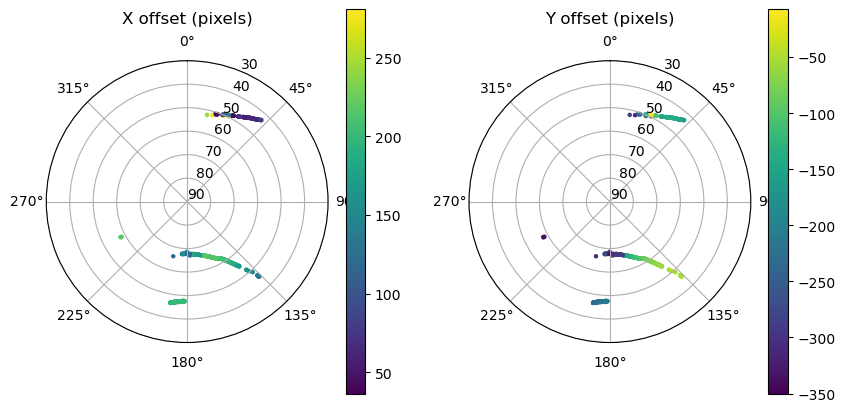

In [118]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='polar')
c = ax.scatter([p[0].asRadians() for p in boresightAzAlts],
               [p[1].asDegrees() for p in boresightAzAlts],
               c=[o[0] for o in offsets],  s=5)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(90, 30)
ax.set_title("X offset (pixels)", va='bottom')
fig.colorbar(c)

ax = fig.add_subplot(122, projection='polar')
c = ax.scatter([p[0].asRadians() for p in boresightAzAlts],
               [p[1].asDegrees() for p in boresightAzAlts],
               c=[o[1] for o in offsets], s=5)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(90, 30)
ax.set_title("Y offset (pixels)", va='bottom')
fig.colorbar(c)

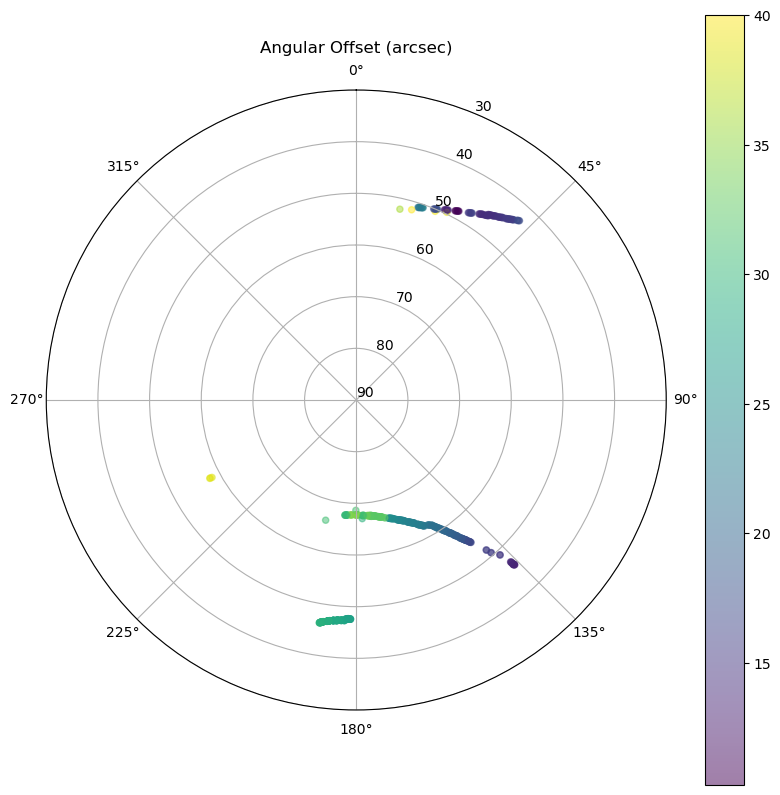

In [111]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter([p[0].asRadians() for p in boresightAzAlts],
               [p[1].asDegrees() for p in boresightAzAlts],
               c=[p.separation(c).asArcseconds() for (p, c) in zip(postIsrCcdPos, calexpPos)],
               s=20, alpha=0.5)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(90, 30)
ax.set_title("Angular Offset (arcsec)", va='bottom')
fig.colorbar(c)